## Fine-Tune CB-BERT for CBDC Sentence Classification using Google Colab + GPU

### Overview

This notebook fine-tunes the **domain-adapted BERT model** [`bilalzafar/CentralBank-BERT`](https://huggingface.co/bilalzafar/CentralBank-BERT) for binary classification of sentences as **CBDC-related** or **not**.

The model has already been pre-trained on 2+ million sentences from **central bank speeches** (1996–2024), making it highly specialized for monetary policy, financial regulation, and macroeconomic communication.

---

### Features

* Uses **HuggingFace Transformers** and **Datasets** for preprocessing, tokenization, and model training.
* Loads the **CB-BERT** tokenizer to preserve domain-specific vocabulary.
* Initializes a **sequence classification head** on top of the CB-BERT encoder.
* Trains and evaluates on a labeled dataset of CBDC-related sentences.
* Reports **Accuracy** and **F1-score** on the test set.

---

### Steps

1. **Setup Environment**
   Install required libraries and mount Google Drive.

2. **Load Data**
   Load the CSV file containing labeled sentences (`sentence` column) and binary labels (`label` column).

3. **Split Data**
   Stratified split into **train (80%)** and **test (20%)**.

4. **Tokenization**
   Tokenize using the **CB-BERT tokenizer** with a maximum length of 128 tokens.

5. **Model Loading**
   Load `bilalzafar/cb-bert-mlm` with a **new classification head** for binary output.

6. **Training**
   Fine-tune with the HuggingFace `Trainer` API, evaluating at the end of each epoch.

7. **Evaluation**
   Compute Accuracy and F1-score on the held-out test set.


In [ ]:
# 1. Install and upgrade dependencies
# !pip install -U transformers datasets scikit-learn tqdm --quiet

# 2. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 3. Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import set_seed
set_seed(42)

# 4. Load data
file_path = "/content/drive/MyDrive/cbdc-bert/bert_training_data.csv"
df = pd.read_csv(file_path)
print(f"Loaded {len(df)} rows: {df.columns.tolist()}")
print(df.head())

# 5. Train/Test split
train_df, test_df = train_test_split(
    df[['sentence', 'label']],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

# 6. Tokenization
checkpoint = "bilalzafar/cb-bert-mlm" # now updated the model name as bilalzafar/CentralBank-BERT
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=128)

print("Tokenizing train...")
train_ds = train_ds.map(tokenize, batched=True, batch_size=256, desc="Tokenizing train")
print("Tokenizing test...")
test_ds  = test_ds.map(tokenize,  batched=True, batch_size=256, desc="Tokenizing test")

train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# 7. Load BERT for classification
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=2
)

# 8. Training arguments
training_args = TrainingArguments(
    output_dir="/content/bert_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="/content/logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_strategy="steps",
    save_total_limit=2,
    report_to="none"
)

# 9. Compute metrics function
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # For 2 classes, default 'binary' is fine if labels are {0,1}
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# 10. Trainer & training
print("Training starting...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()
print("Training complete.")

# 11. Evaluate & Save
print("Final evaluation on test set:")
eval_result = trainer.evaluate()
print(eval_result)

save_path = "/content/drive/MyDrive/cbdc-bert/cbdc-bert-model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Model saved to: {save_path}")


Mounted at /content/drive
Loaded 11000 rows: ['url', 'sentence', 'label']
                                       url  \
0  https://www.bis.org/review/r170609c.htm   
1  https://www.bis.org/review/r200715f.htm   
2  https://www.bis.org/review/r050624b.pdf   
3   http://www.bis.org/review/r230503e.htm   
4   http://www.bis.org/review/r220928e.htm   

                                            sentence  label  
0  central banks are now carefully monitoring new...      1  
1  (2020), bundesbank round-up, deutsche bundesba...      0  
2  these three major improvements - namely foster...      0  
3  this central bank digital currency is being us...      1  
4  almost all of that attention is focused on ret...      1  
Train: 8800, Test: 2200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Tokenizing train...


Tokenizing train:   0%|          | 0/8800 [00:00<?, ? examples/s]

Tokenizing test...


Tokenizing test:   0%|          | 0/2200 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bilalzafar/cb-bert-mlm and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1685137121.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training starting...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.106600,0.041135,0.990455,0.990309
2,0.000500,0.029040,0.995000,0.994905
3,0.000100,0.039434,0.993636,0.993525


Training complete.
Final evaluation on test set:


{'eval_loss': 0.029039772227406502, 'eval_accuracy': 0.995, 'eval_f1': 0.9949050486336267, 'eval_runtime': 16.665, 'eval_samples_per_second': 132.013, 'eval_steps_per_second': 16.502, 'epoch': 3.0}
Model saved to: /content/drive/MyDrive/cbdc-bert/cbdc-bert-model


CBDC-BERT Evaluation
--------------------

This script evaluates the fine-tuned CBDC-BERT model on a held-out 20% test set.
It reports classification metrics, shows ROC-AUC, confusion matrix, and saves key plots.

Class Distribution in Test Set:
label
0    1109
1    1066
Name: count, dtype: int64



⚡ Predicting: 100%|████████████████████████████████████████████████| 34/34 [00:14<00:00,  2.37it/s]
/tmp/ipython-input-3816272714.py:72: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  plt.savefig(cm_path, format='svg')



Classification Report:
              precision    recall  f1-score   support

    Non-CBDC       1.00      1.00      1.00      1109
        CBDC       1.00      1.00      1.00      1066

    accuracy                           1.00      2175
   macro avg       1.00      1.00      1.00      2175
weighted avg       1.00      1.00      1.00      2175

Accuracy: 0.9977


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


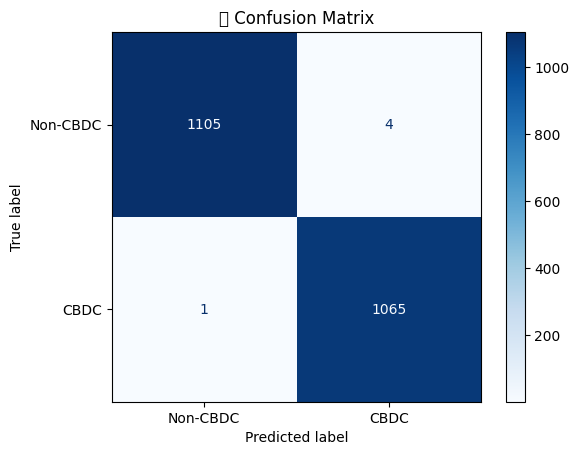

💾 Confusion matrix saved to: /content/drive/My Drive/cbdc-bert/Evaluation/confusion_matrix.svg


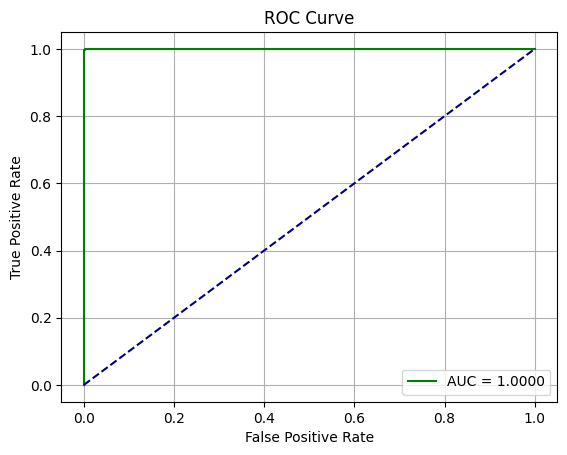

ROC curve saved to: /content/drive/My Drive/cbdc-bert/Evaluation/roc_curve.svg
ROC AUC Score: 1.0000

❌ False Positives (Non-CBDC predicted as CBDC):
 - denis beau: the perils and potential of digital currencies introductory remarks (virtual) by mr denis beau, first deputy governor of the bank of france, for the panel discussion on "the perils and potential of digital currencies", at the raid (regulation, artificial intelligence, internet & data) digital 2023 on "bridging parallel lines", 3 may 2023.
 - the aim would be to provide a kind of "digital banknote", which would combine the security of banknotes issued by the central bank with the ease of use and innovation of dematerialised means of payment.
 - 13. will central-bank digital currencies break the banking system?, the economist, 3 december 2020. https://www.bundesbank.de/en/press/speeches/welcoming-address-at-the-bundesbank-symposium-banking-supervision-in-dialogue--874968
 - amando m tetangco, jr: consultation, collaboration a

In [2]:
# 1️ Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import torch

# 2️ Load model & tokenizer (and move model to GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/My Drive/cbdc-bert/cbdc-bert-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
model.eval()

# 3️ Load and prepare test data
data_path = "/content/drive/My Drive/cbdc-bert/bert_training_data.csv"
df = pd.read_csv(data_path).drop_duplicates(subset="sentence")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 4️ Stratified test set (20%)
_, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# 5️ Report class balance
print("Class Distribution in Test Set:")
print(test_df['label'].value_counts())
print()

# 6️ Prediction function (batched with progress bar + GPU)
def predict_sentences(sentences, batch_size=64):
    preds, probs = [], []
    for i in tqdm(range(0, len(sentences), batch_size), desc="⚡ Predicting", ncols=100):
        batch = sentences[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            prob = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()
            preds += list(np.argmax(prob, axis=1))
            probs += list(prob[:, 1])  # class 1 = CBDC
    return np.array(preds), np.array(probs)

# 7️ Predict and evaluate
y_true = test_df["label"].values
y_pred, y_prob = predict_sentences(test_df["sentence"].tolist())

# 8 Print metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-CBDC", "CBDC"]))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# 9️ Create output folder
output_dir = "/content/drive/My Drive/cbdc-bert/Evaluation"
os.makedirs(output_dir, exist_ok=True)

# 10 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-CBDC", "CBDC"])
disp.plot(cmap="Blues", values_format='d')
plt.title("🧾 Confusion Matrix")
plt.grid(False)
cm_path = os.path.join(output_dir, "confusion_matrix.svg")
plt.savefig(cm_path, format='svg')
plt.show()
print(f"💾 Confusion matrix saved to: {cm_path}")

# 11 ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
roc_path = os.path.join(output_dir, "roc_curve.svg")
plt.savefig(roc_path, format='svg')
plt.show()
print(f"ROC curve saved to: {roc_path}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# 12 View misclassified examples
print("\n❌ False Positives (Non-CBDC predicted as CBDC):")
for s in test_df[(y_true == 0) & (y_pred == 1)]["sentence"].head(5):
    print(" -", s)

print("\n❌ False Negatives (CBDC predicted as Non-CBDC):")
for s in test_df[(y_true == 1) & (y_pred == 0)]["sentence"].head(5):
    print(" -", s)


Brier Score Evaluation for CBDC-BERT
------------------------------------

This script computes the Brier Score to evaluate the calibration quality of predicted probabilities
from the CBDC-BERT model. The Brier Score measures the mean squared difference between predicted
probabilities and the actual binary outcomes (labels). Lower scores indicate better-calibrated
confidence outputs.

Interpretation thresholds:
- < 0.05 → Excellent calibration
- < 0.10 → Good calibration
- < 0.20 → Moderate calibration
- ≥ 0.20 → Poor calibration

This is particularly useful when using the model in sensitive or high-stakes environments
like financial regulation or central banking, where reliable confidence scores matter.

In [3]:
from sklearn.metrics import brier_score_loss

# You already have:
# y_true → true labels (0 or 1)
# y_prob → predicted probability for class 1 (AI)

# Compute Brier Score
brier_score = brier_score_loss(y_true, y_prob)

print(f"📏 Brier Score: {brier_score:.4f}")

# Optional interpretation
if brier_score < 0.05:
    interpretation = "Excellent calibration"
elif brier_score < 0.10:
    interpretation = "Good calibration"
elif brier_score < 0.20:
    interpretation = "Moderate calibration"
else:
    interpretation = "Poor calibration"

print(f"🧠 Interpretation: {interpretation}")

📏 Brier Score: 0.0024
🧠 Interpretation: Excellent calibration


"""
CBDC Sentence Classification Test with Ground Truth Comparison
--------------------------------------------------------------

This script loads the fine-tuned CBDC-BERT model and evaluates its performance on a set of labeled test sentences.
Each sentence has a predefined ground truth label ('CBDC' or 'Non-CBDC'), allowing comparison between the model's
predictions and expected outcomes.

For each input, the script outputs:
- The sentence
- The model’s predicted label
- The confidence score for the 'CBDC' class
- The ground truth label

This enables quick evaluation of classification accuracy.
"""


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

# === Load model & tokenizer ===
model_path = "/content/drive/My Drive/cbdc-bert/cbdc-bert-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# === Input sample sentences with ground truth labels ===
samples = [
    # === CBDC-related (label: "CBDC") ===
    ("The central bank is exploring the issuance of a digital euro for retail use.", "CBDC"),
    ("A blockchain-based platform is being tested for wholesale CBDC transactions between banks.", "CBDC"),
    ("Unlike traditional bank deposits, central bank digital currencies are direct liabilities of the state.", "CBDC"),
    ("The digital rupee aims to enhance financial inclusion through secure mobile payments.", "CBDC"),
    ("Central banks are coordinating on cross-border CBDC trials to improve international settlement systems.", "CBDC"),
    ("CBDCs must ensure user privacy while complying with anti-money laundering regulations.", "CBDC"),
    ("Retail CBDC will coexist with cash and bank deposits in the new monetary landscape.", "CBDC"),
    ("The central bank is considering setting limits on CBDC holdings to avoid disintermediation.", "CBDC"),
    ("The Federal Reserve is conducting public consultations on the risks and benefits of issuing a digital dollar.", "CBDC"),
    ("Central bank digital money could transform monetary policy transmission in a low interest rate environment.", "CBDC"),

    # === Near-CBDC / Ambiguous (label: "Non-CBDC") ===
    ("Bitcoin and stablecoins continue to challenge the traditional financial system.", "Non-CBDC"),
    ("Private digital currencies are increasingly being used for cross-border payments.", "Non-CBDC"),
    ("E-money providers are expanding access through mobile platforms in rural areas.", "Non-CBDC"),
    ("The financial sector is undergoing rapid digitization with AI and big data adoption.", "Non-CBDC"),

    # === Clear Non-CBDC (label: "Non-CBDC") ===
    ("The stock market rallied after positive earnings reports from tech companies.", "Non-CBDC"),
    ("Weather forecasts show heavy rainfall expected in the northern region this week.", "Non-CBDC"),
    ("Tourism has increased significantly due to relaxed visa policies.", "Non-CBDC"),
    ("Students are preparing for their final exams in September.", "Non-CBDC"),
]

# Separate sentences and labels
sentences, prelabels = zip(*samples)

# === Predict ===
inputs = tokenizer(list(sentences), padding=True, truncation=True, return_tensors="pt", max_length=128)
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

# === Format results ===
results = []
correct = 0
for sent, prob, prelabel in zip(sentences, probs, prelabels):
    pred_label = "CBDC" if prob[1] > 0.5 else "Non-CBDC"
    score = round(float(prob[1]), 4)  # probability of CBDC class
    is_correct = pred_label == prelabel
    if is_correct:
        correct += 1
    results.append((sent, pred_label, score, prelabel, is_correct))

# === Display as DataFrame ===
df = pd.DataFrame(results, columns=["Sentence", "Prediction", "Score", "Prelabel", "Correct"])
print(df)

# === Accuracy Summary ===
accuracy = round((correct / len(samples)) * 100, 2)
print(f"\nModel Accuracy: {accuracy}% ({correct} out of {len(samples)} correct predictions)")


                                             Sentence Prediction   Score  \
0   The central bank is exploring the issuance of ...       CBDC  0.9998   
1   A blockchain-based platform is being tested fo...       CBDC  0.9999   
2   Unlike traditional bank deposits, central bank...       CBDC  0.9992   
3   The digital rupee aims to enhance financial in...       CBDC  0.9981   
4   Central banks are coordinating on cross-border...       CBDC  0.9999   
5   CBDCs must ensure user privacy while complying...       CBDC  0.9999   
6   Retail CBDC will coexist with cash and bank de...       CBDC  0.9999   
7   The central bank is considering setting limits...       CBDC  0.9999   
8   The Federal Reserve is conducting public consu...       CBDC  0.9986   
9   Central bank digital money could transform mon...       CBDC  0.9994   
10  Bitcoin and stablecoins continue to challenge ...   Non-CBDC  0.0001   
11  Private digital currencies are increasingly be...   Non-CBDC  0.0001   
12  E-money 

"""
CBDC-BERT Robustness and Sensitivity Evaluation
-----------------------------------------------

This script tests the robustness of the fine-tuned CBDC-BERT model using custom-designed
edge cases, noise-injected inputs, syntactically altered sentences, and paraphrased (translated-like)
examples. Each test includes expected labels, and the model's predictions are compared against them.

The script outputs:
- Detailed per-sentence predictions with confidence scores.
- A summary table of accuracy across each robustness category.

Categories Tested:
- Edge Cases: Legitimate but ambiguous central banking sentences.
- Noise-Injected: Typo, symbol, or formatting errors.
- Translated: Paraphrased or slightly reworded variants.
- Syntactically Altered: Same meaning but with changed structure.

In [5]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# === Load CBDC-BERT Model ===
model_path = "/content/drive/My Drive/cbdc-bert/cbdc-bert-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# === Define Robust Test Cases (10 per category) ===
robust_tests = {
    "Edge Cases": [
        ("We enhanced digital infrastructure and monitoring systems.", 0),
        ("Predictive tools were discussed in our IT committee.", 0),
        ("CBDC principles were highlighted in the internal review.", 1),
        ("Central bank agenda on digital currency.", 1),
        ("Modern payment rails were prioritized.", 0),
        ("Digital settlements gained policy attention.", 1),
        ("Technology in currency issuance was explored by central bankers.", 1),
        ("Reserve management includes digital asset discussions.", 0),
        ("Stablecoins and CBDCs were jointly addressed.", 1),
        ("Audit mentioned ledger modernization.", 0)
    ],
    "Noise-Injected": [
        ("Central bank digtal currency was mentiond in...?!", 1),
        ("CBDC is under--discusssion at BoE!!", 1),
        ("Digital currency..yep, important maybe.", 1),
        ("Digi settlement sys adopted.", 0),
        ("Issuance of cbdc. or maybe not.", 1),
        ("Central, bank,, and cBDC policy... yeah.", 1),
        ("Ledger?! Reform? CBDC?", 1),
        ("CBDC!?!", 1),
        ("Digital cash.", 0),
        ("inflation, monetary, fiscal... boring", 0)
    ],
    "Translated": [
        ("Central banks are evaluating digital currency options.", 1),
        ("A new payment infrastructure is being tested.", 0),
        ("CBDCs could improve domestic and cross-border payments.", 1),
        ("Technology is enabling faster financial transfers.", 0),
        ("Digital form of cash is in pilot phase.", 1),
        ("CBDCs offer programmable money capabilities.", 1),
        ("Monetary authorities explore sovereign digital currencies.", 1),
        ("The reform targets efficiency in payment systems.", 0),
        ("Retail CBDC adoption varies by jurisdiction.", 1),
        ("Open banking regulation was finalized.", 0)
    ],
    "Syntactically Altered": [
        ("CBDC pilots were initiated by the central bank.", 1),
        ("Discussions around central bank's digital money are ongoing.", 1),
        ("Efficiency gains expected from digitizing settlements.", 0),
        ("Central dank digital currency trials continue globally.", 1),
        ("Cash alternatives are growing in prominence.", 0),
        ("Authorities debate the future of money tech.", 1),
        ("Issuance models for CBDCs are under review.", 1),
        ("Digital currencies? Still evolving topic.", 1),
        ("Crypto-assets are being monitored closely.", 0),
        ("Central banks issue guidance on digital tools.", 0)
    ]
}

# === Predict Function ===
def predict_with_scores(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1).tolist()
        scores = probs[:, 1].tolist()  # Confidence for CBDC class
    return preds, scores

# === Evaluation ===
all_results = []

for category, test_cases in robust_tests.items():
    sentences, expected = zip(*test_cases)
    preds, scores = predict_with_scores(sentences)
    for s, e, p, score in zip(sentences, expected, preds, scores):
        all_results.append({
            "Category": category,
            "Sentence": s,
            "Expected": e,
            "Predicted": p,
            "Confidence (CBDC)": round(score, 3),
            "Correct": int(p == e)
        })

# === Display Detailed Results ===
df_results = pd.DataFrame(all_results)
print(df_results.to_string(index=False))

# === Summary Table ===
summary = (
    df_results.groupby("Category")["Correct"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "Correct", "count": "Total"})
)
summary["Accuracy (%)"] = round(100 * summary["Correct"] / summary["Total"], 2)

print("\n📊 Robustness Summary:")
print(summary)


             Category                                                         Sentence  Expected  Predicted  Confidence (CBDC)  Correct
           Edge Cases       We enhanced digital infrastructure and monitoring systems.         0          0              0.000        1
           Edge Cases             Predictive tools were discussed in our IT committee.         0          0              0.000        1
           Edge Cases         CBDC principles were highlighted in the internal review.         1          1              1.000        1
           Edge Cases                         Central bank agenda on digital currency.         1          1              0.999        1
           Edge Cases                           Modern payment rails were prioritized.         0          0              0.000        1
           Edge Cases                     Digital settlements gained policy attention.         1          0              0.000        0
           Edge Cases Technology in currency iss

CBDC Sentence Classification with Traditional ML Models
-------------------------------------------------------

This script evaluates multiple traditional machine learning classifiers for the task of
classifying central bank speech sentences as CBDC-related or not. It uses TF-IDF feature
representation and tests four popular models:

- Logistic Regression
- Multinomial Naive Bayes
- Random Forest
- XGBoost

In [10]:
# Clean, pinned installs BEFORE imports
!pip install -U "scikit-learn>=1.5.1,<1.6" pandas matplotlib "xgboost>=2.0.0" --quiet

import sklearn, numpy, xgboost, matplotlib
print("sklearn:", sklearn.__version__)
print("numpy:", numpy.__version__)
print("xgboost:", xgboost.__version__)
print("matplotlib:", matplotlib.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 110.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
sklearn: 1.6.1
numpy: 2.0.2
xgboost: 3.0.4
matplotlib: 3.10.0


Loaded 11000 sentences (CBDC + Non-CBDC)

🔍 Evaluating: Logistic Regression
📊 Classification Report:
              precision    recall  f1-score   support

    Non-CBDC       0.97      0.98      0.97      1122
        CBDC       0.98      0.96      0.97      1078

    accuracy                           0.97      2200
   macro avg       0.97      0.97      0.97      2200
weighted avg       0.97      0.97      0.97      2200

📁 Saved plot: /content/drive/My Drive/cbdc-bert/ML-Eval/Logistic_Regression_confusion.svg


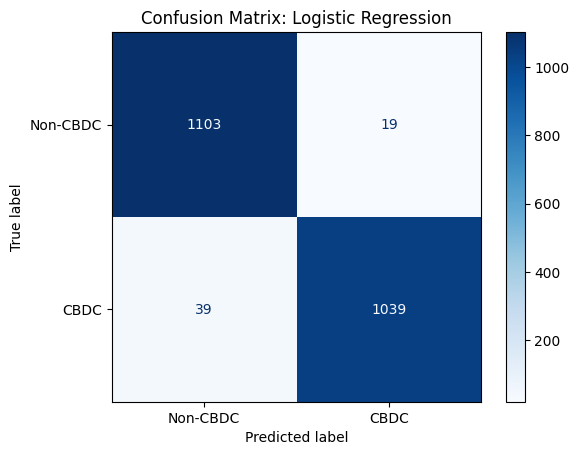


🔍 Evaluating: Naive Bayes
📊 Classification Report:
              precision    recall  f1-score   support

    Non-CBDC       0.95      0.88      0.91      1122
        CBDC       0.88      0.95      0.92      1078

    accuracy                           0.92      2200
   macro avg       0.92      0.92      0.92      2200
weighted avg       0.92      0.92      0.92      2200

📁 Saved plot: /content/drive/My Drive/cbdc-bert/ML-Eval/Naive_Bayes_confusion.svg


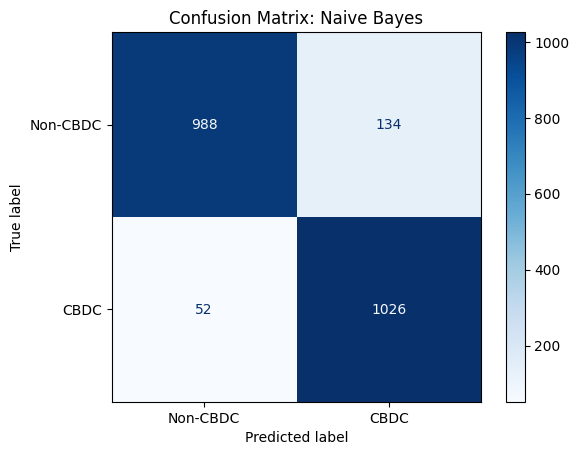


🔍 Evaluating: Random Forest
📊 Classification Report:
              precision    recall  f1-score   support

    Non-CBDC       0.99      0.97      0.98      1122
        CBDC       0.97      0.99      0.98      1078

    accuracy                           0.98      2200
   macro avg       0.98      0.98      0.98      2200
weighted avg       0.98      0.98      0.98      2200

📁 Saved plot: /content/drive/My Drive/cbdc-bert/ML-Eval/Random_Forest_confusion.svg


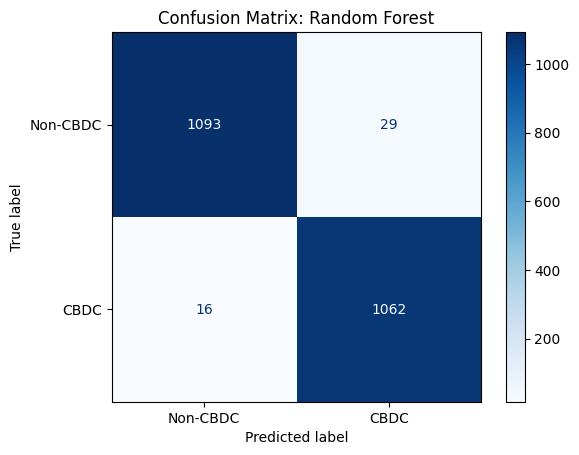


🔍 Evaluating: XGBoost
📊 Classification Report:
              precision    recall  f1-score   support

    Non-CBDC       0.98      0.99      0.99      1122
        CBDC       0.99      0.98      0.99      1078

    accuracy                           0.99      2200
   macro avg       0.99      0.99      0.99      2200
weighted avg       0.99      0.99      0.99      2200

📁 Saved plot: /content/drive/My Drive/cbdc-bert/ML-Eval/XGBoost_confusion.svg


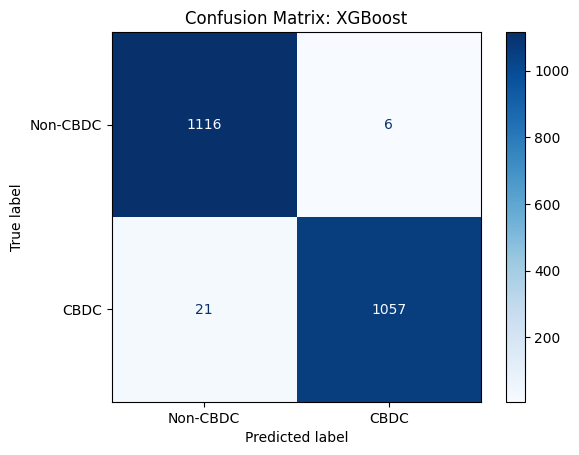

In [1]:
# 1. Install dependencies
# !pip install -U scikit-learn pandas matplotlib xgboost --quiet

# 2. Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# 3. Load already balanced dataset
df = pd.read_csv("/content/drive/My Drive/cbdc-bert/bert_training_data.csv")
print(f"Loaded {len(df)} sentences (CBDC + Non-CBDC)")

# 4. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    df['sentence'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=42
)

# 5. TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 6. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
}

# 7. Output folder for saving plots
output_dir = "/content/drive/My Drive/cbdc-bert/ML-Eval"
os.makedirs(output_dir, exist_ok=True)

# 8. Evaluate and save
for name, model in models.items():
    print(f"\n🔍 Evaluating: {name}")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Non-CBDC", "CBDC"]))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-CBDC", "CBDC"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)

    # Save plot as SVG
    plot_path = os.path.join(output_dir, f"{name.replace(' ', '_')}_confusion.svg")
    plt.savefig(plot_path, format="svg")
    print(f"📁 Saved plot: {plot_path}")
    plt.show()


CBDC-BERT Sentence Length Bias Analysis
---------------------------------------

This script evaluates whether the CBDC-BERT model’s predictions are biased by sentence length.

Evaluating sentence length bias (batched on GPU)...


Scoring batches: 100%|██████████| 170/170 [01:10<00:00,  2.41it/s]
/tmp/ipython-input-1579140023.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = df.groupby("bin")[["length", "score"]].mean().dropna()


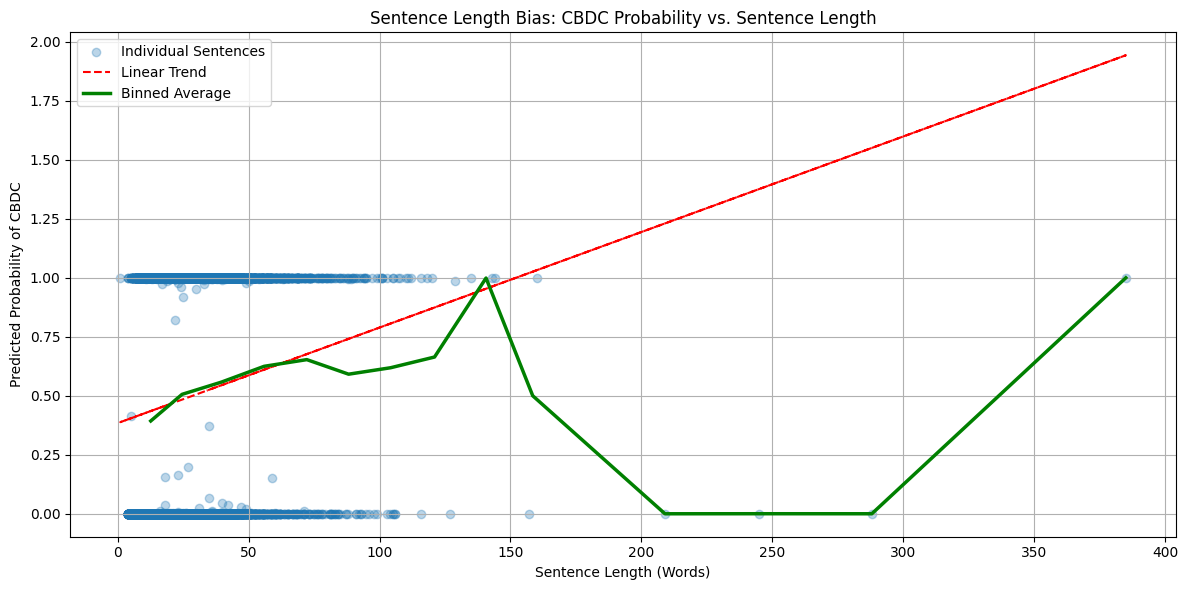

📍 Plot saved to: /content/drive/My Drive/cbdc-bert/Sentence Bias Plots/sentence_length_bias.svg
📈 Correlation between sentence length and CBDC probability: 0.1222


In [3]:
# === 1. Imports ===
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# === 2. Load model and tokenizer ===
model_path = "/content/drive/My Drive/cbdc-bert/cbdc-bert-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# === 3. Load dataset ===
data_path = "/content/drive/My Drive/cbdc-bert/bert_training_data.csv"
df = pd.read_csv(data_path).drop_duplicates(subset="sentence").reset_index(drop=True)

# === 4. Prediction with batching (GPU) ===
batch_size = 64
lengths, scores = [], []

print("Evaluating sentence length bias (batched on GPU)...")
for i in tqdm(range(0, len(df), batch_size), desc="Scoring batches"):
    batch = df["sentence"][i:i+batch_size].tolist()
    batch_lengths = [len(s.split()) for s in batch]

    inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1].detach().cpu().numpy()

    lengths.extend(batch_lengths)
    scores.extend(probs)

df["length"] = lengths
df["score"] = scores

# === 5. Plot: Sentence Length vs. CBDC Probability ===
plt.figure(figsize=(12, 6))
plt.scatter(df["length"], df["score"], alpha=0.3, label="Individual Sentences")

# Regression line
z = np.polyfit(df["length"], df["score"], 1)
p = np.poly1d(z)
plt.plot(df["length"], p(df["length"]), "r--", label="Linear Trend")

# Binned averages
bins = np.linspace(df["length"].min(), df["length"].max(), 25)
df["bin"] = pd.cut(df["length"], bins)
bin_avg = df.groupby("bin")[["length", "score"]].mean().dropna()
plt.plot(bin_avg["length"], bin_avg["score"], color="green", linewidth=2.5, label="Binned Average")

# Decorate
plt.xlabel("Sentence Length (Words)")
plt.ylabel("Predicted Probability of CBDC")
plt.title("Sentence Length Bias: CBDC Probability vs. Sentence Length")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save and show
plot_folder = "/content/drive/My Drive/cbdc-bert/Sentence Bias Plots"
os.makedirs(plot_folder, exist_ok=True)
plot_path = os.path.join(plot_folder, "sentence_length_bias.svg")
plt.savefig(plot_path, format="svg")
plt.show()
print(f"📍 Plot saved to: {plot_path}")

# === 6. Correlation ===
corr = np.corrcoef(df["length"], df["score"])[0, 1]
print(f"📈 Correlation between sentence length and CBDC probability: {corr:.4f}")
